# Học biểu diễn dữ liệu graph sử dụng GraphSage

## Dataset

### Protein-Protein interaction

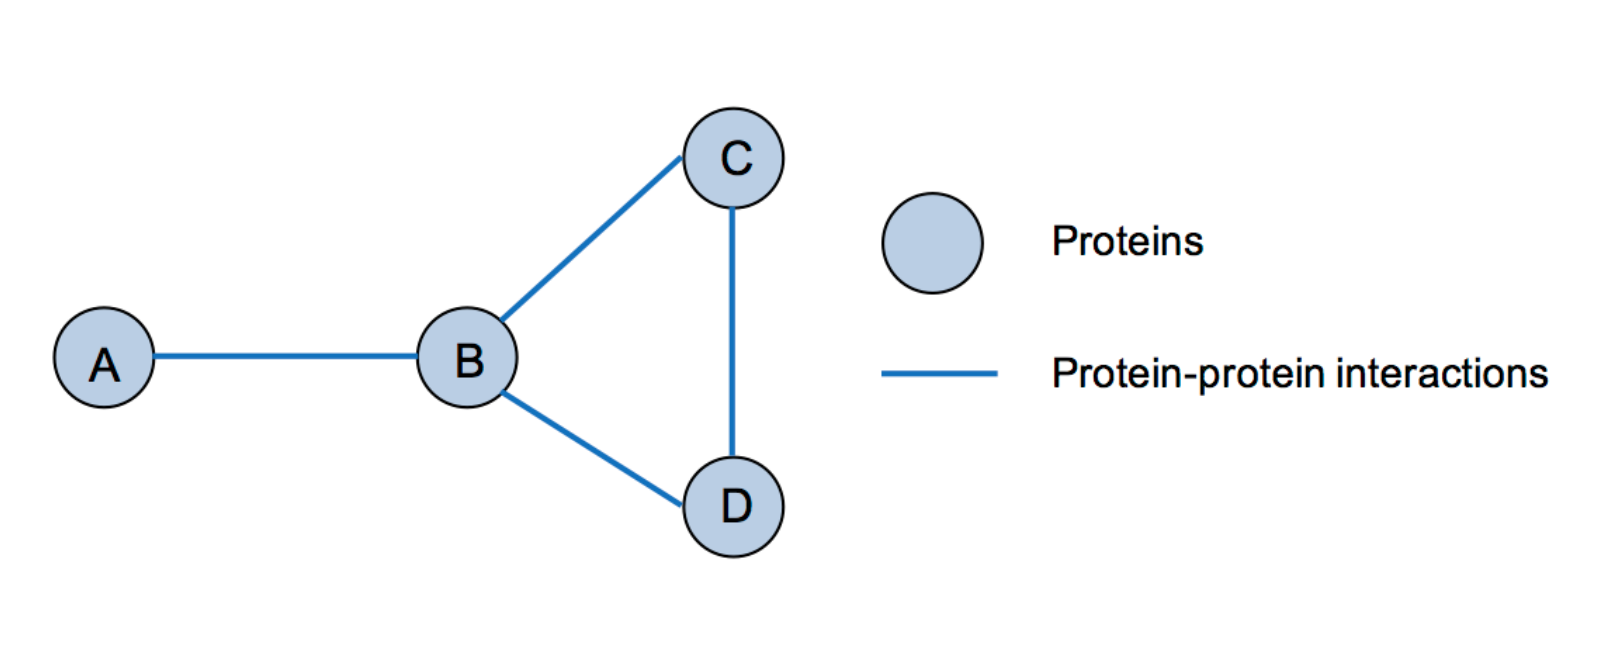

Tương tác protein là hiện tượng vật lý mà hai hay nhiều protein bám vào nhau, là trung tâm của mọi quá trình sinh học diễn ra trong tế bào.
Các proteins được biểu diễn bằng các nodes, liên kết bởi các edges vô hướng.

Tương tác protein-protein (PPI) là điều cần thiết cho hầu hết mọi quá trình trong tế bào, vì vậy hiểu PPI là rất quan trọng để hiểu sinh lý tế bào ở trạng thái bình thường và bệnh. Nó cũng rất cần thiết trong việc phát triển thuốc, vì thuốc có thể ảnh hưởng đến PPI.

#### Định dạng dữ liệu

* toy-ppi-G.json -- A networkx-specified json file describing the input graph. Nodes have 'val' and 'test' attributes specifying if they are a part of the validation and test sets, respectively.
* toy-ppi-id_map.json -- A json-stored dictionary mapping the graph node ids to consecutive integers.
* toy-ppi-class_map.json -- A json-stored dictionary mapping the graph node ids to classes.
* toy-ppi-feats.npy [optional] --- A numpy-stored array of node features; ordering given by id_map.json. Can be omitted and only identity features will be used.
* toy-ppi-walks.txt [optional] --- A text file specifying random walk co-occurrences (one pair per line) (*only for unsupervised version of graphsage)

## Thử nghiệm trên dữ liệu PPI

### Phân loại Protein chỉ sử dụng Features

In [1]:
import numpy as np
from networkx.readwrite import json_graph
import json
import os
cwd = os.getcwd()

dataset_dir = cwd + '/example_data/'

Tải bộ dữ liệu *toy-ppi* từ thư mục *'example_data'* vào đối tượng Graph của networkx. Phân tách các nodes thành tập huấn luyện và tập kiểm thử.

In [2]:
print("Loading data...")
G = json_graph.node_link_graph(json.load(open(dataset_dir + "/toy-ppi-G.json")))
labels = json.load(open(dataset_dir + "/toy-ppi-class_map.json"))
labels = {int(i):l for i, l in labels.items()}
    
train_ids = [n for n in G.nodes() if not G.node[n]['val'] and not G.node[n]['test']]
test_ids = [n for n in G.nodes() if G.node[n]['test']]
train_labels = np.array([labels[i] for i in train_ids])
if train_labels.ndim == 1:
    train_labels = np.expand_dims(train_labels, 1)
test_labels = np.array([labels[i] for i in test_ids])
print("Loaded data")

Loading data...
Loaded data


Hàm huấn luyện mô hình hồi quy trên dữ liệu

In [6]:
def run_regression(train_embeds, train_labels, test_embeds, test_labels):
    np.random.seed(1)
    from sklearn.linear_model import SGDClassifier
    from sklearn.dummy import DummyClassifier
    from sklearn.metrics import f1_score
    from sklearn.multioutput import MultiOutputClassifier
    dummy = MultiOutputClassifier(DummyClassifier())
    dummy.fit(train_embeds, train_labels)
    log = MultiOutputClassifier(SGDClassifier(loss="log", max_iter=5, tol=-np.infty), n_jobs=10)
    log.fit(train_embeds, train_labels)

    f1 = 0
    for i in range(test_labels.shape[1]):
        print("F1 score", f1_score(test_labels[:,i], log.predict(test_embeds)[:,i], average="micro"))
    for i in range(test_labels.shape[1]):
        print("Random baseline F1 score", f1_score(test_labels[:,i], dummy.predict(test_embeds)[:,i], average="micro"))

Đọc và sử dụng trực tiếp features của proteins cho phân loại 

In [14]:
feats = np.load(dataset_dir + "/toy-ppi-feats.npy")
## Logistic gets thrown off by big counts, so log transform num comments and score
feats[:,0] = np.log(feats[:,0]+1.0)
feats[:,1] = np.log(feats[:,1]-min(np.min(feats[:,1]), -1))
feat_id_map = json.load(open(dataset_dir + "/toy-ppi-id_map.json"))
feat_id_map = {int(id):val for id,val in feat_id_map.items()}
train_feats = feats[[feat_id_map[id] for id in train_ids]] 
test_feats = feats[[feat_id_map[id] for id in test_ids]] 
print("Running regression..")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_feats)
train_feats = scaler.transform(train_feats)
test_feats = scaler.transform(test_feats)
run_regression(train_feats, train_labels, test_feats, test_labels)

Running regression..
F1 score 0.5609831985065339
F1 score 0.7047293092719353
F1 score 0.7028624766645925
F1 score 0.7377100186683262
F1 score 0.814250155569384
F1 score 0.7345986309894211
F1 score 0.7296204107031737
F1 score 0.6263223397635346
F1 score 0.7990043559427504
F1 score 0.6369010578718108
F1 score 0.7146857498444306
F1 score 0.7069072806471687
F1 score 0.6172993154947106
F1 score 0.7286869943995021
F1 score 0.7996266334785315
F1 score 0.6051649035469819
F1 score 0.8736776602364654
F1 score 0.7790914747977598
F1 score 0.7115743621655259
F1 score 0.5609831985065339
F1 score 0.7629122588674548
F1 score 0.5413814561294338
F1 score 0.7062850031113876
F1 score 0.6247666459240822
F1 score 0.8270068450528936
F1 score 0.48070939639079036
F1 score 0.6060983198506534
F1 score 0.6120099564405725
F1 score 0.6384567517112633
F1 score 0.7560672059738642
F1 score 0.5662725575606721
F1 score 0.813627878033603
F1 score 0.8503422526446796
F1 score 0.7890479153702551
F1 score 0.6683260734287492


Random baseline F1 score 0.5731176104542626
Random baseline F1 score 0.723397635345364
Random baseline F1 score 0.6051649035469819
Random baseline F1 score 0.5992532669570628
Random baseline F1 score 0.6901057871810827
Random baseline F1 score 0.5161792159303049
Random baseline F1 score 0.7899813316739267
Random baseline F1 score 0.6204107031736155
Random baseline F1 score 0.6904169259489732
Random baseline F1 score 0.5130678282514001
Random baseline F1 score 0.6518357187305538


### Phân loại Proteins sử dụng protein features và topology information

Chạy module unsupervised_train trên tập dữ liệu toy-ppi, với mean-based aggregator.
Học viên có thể thử thay đổi aggregator: graphsage_seq; graphsage_maxpool; graphsage_meanpool; gcn; n2v

In [9]:
!python -m graphsage.unsupervised_train --train_prefix ./example_data/toy-ppi --model graphsage_mean --max_total_steps 1000 --validate_iter 10

Loading training data..
Removed 0 nodes that lacked proper annotations due to networkx versioning issues
Loaded data.. now preprocessing..
Done loading training data..
Unexpected missing: 0
9716 train nodes
5039 test nodes
Epoch: 0001
Iter: 0000 train_loss= 18.92536 train_mrr= 0.21162 train_mrr_ema= 0.21162 val_loss= 19.06279 val_mrr= 0.21292 val_mrr_ema= 0.21292 time= 0.88763
Iter: 0050 train_loss= 18.59980 train_mrr= 0.18058 train_mrr_ema= 0.20322 val_loss= 18.54616 val_mrr= 0.24555 val_mrr_ema= 0.20442 time= 0.11471
Iter: 0100 train_loss= 18.40421 train_mrr= 0.19015 train_mrr_ema= 0.19559 val_loss= 18.31281 val_mrr= 0.19105 val_mrr_ema= 0.21033 time= 0.10413
Iter: 0150 train_loss= 17.84482 train_mrr= 0.18357 train_mrr_ema= 0.19057 val_loss= 17.99726 val_mrr= 0.22713 val_mrr_ema= 0.20806 time= 0.10062
Iter: 0200 train_loss= 17.06038 train_mrr= 0.22295 train_mrr_ema= 0.18745 val_loss= 17.81680 val_mrr= 0.17486 val_mrr_ema= 0.20721 time= 0.09883
Iter: 0250 train_loss= 16.95466 train_mr

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
2019-05-12 00:12:35.518773: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
2019-05-12 00:12:35.748247: E tensorflow/stream_executor/cuda/cuda_driver.cc:300] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2019-05-12 00:12:35.750816: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:161] retrieving CUDA diagnostic information for host: ds
2019-05-12 00:12:35.750994: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:168] hostname: ds


Kết quả embed được lưu xuống tệp *'val.npy'*, gồm các vector *d* chiều biểu diễn các nodes của ppi trong không gian vector.

In [4]:
data_dir = cwd + '/unsup-example_data/graphsage_mean_small_0.000010'

embeds = np.load(data_dir + "/val.npy")
print(embeds)
print(embeds.shape)

[[-0.02339376 -0.07736608  0.07390556 ...  0.02791744  0.02992336
   0.00835237]
 [ 0.04348487 -0.00300906  0.09828716 ...  0.04894466  0.02268369
   0.02823013]
 [ 0.0209066   0.01490901  0.00943893 ... -0.0264275   0.04034643
  -0.09079492]
 ...
 [ 0.02945459 -0.14107776  0.11482595 ...  0.00146212 -0.01215293
   0.02735572]
 [-0.05105993  0.04138687  0.14587364 ... -0.02843542  0.01045339
  -0.05378818]
 [-0.05228232  0.01489407 -0.02910609 ...  0.00488177 -0.01306467
   0.01830669]]
(14755, 256)


Thực hiện phân loại proteins sử dụng mô hình hồi quy trên dữ liệu PPI đã embed 

In [7]:
id_map = {}
with open(data_dir + "/val.txt") as fp:
    for i, line in enumerate(fp):
        id_map[int(line.strip())] = i
train_embeds = embeds[[id_map[id] for id in train_ids]] 
test_embeds = embeds[[id_map[id] for id in test_ids]] 

print("Running regression..")
run_regression(train_embeds, train_labels, test_embeds, test_labels)

Running regression..
F1 score 0.6101431238332297
F1 score 0.7660236465463598
F1 score 0.791537025513379
F1 score 0.7644679527069073
F1 score 0.8612321095208463
F1 score 0.8105164903546982
F1 score 0.7591785936527692
F1 score 0.6630367143746111
F1 score 0.8512756689483509
F1 score 0.6708151835718731
F1 score 0.7949595519601741
F1 score 0.775980087118855
F1 score 0.7009956440572496
F1 score 0.8201617921593031
F1 score 0.8226509023024269
F1 score 0.6406347230864966
F1 score 0.8926571250777847
F1 score 0.8590541381456129
F1 score 0.6978842563783447
F1 score 0.5920970752955819
F1 score 0.8126944617299315
F1 score 0.6316116988176727
F1 score 0.7840696950840075
F1 score 0.6319228375855631
F1 score 0.8394523957685127
F1 score 0.6182327317983821
F1 score 0.6664592408214064
F1 score 0.6997510889856876
F1 score 0.6901057871810827
F1 score 0.8329184816428128
F1 score 0.6673926571250778
F1 score 0.8528313627878034
F1 score 0.8833229620410703
F1 score 0.8462974486621033
F1 score 0.7990043559427504
F

Random baseline F1 score 0.7899813316739267
Random baseline F1 score 0.6204107031736155
Random baseline F1 score 0.6904169259489732
Random baseline F1 score 0.5130678282514001
Random baseline F1 score 0.6518357187305538
